In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Generating Synthetic Data

The following code generates synthetic data by sampling from two Gaussian distributions with specified means and standard deviations.

In [29]:
np.random.seed(42) # set seed for reproducibility

# K: number of components (Gaussian)
# D: dimension of each Gaussian
n_samples = 500

# 1D example
# true_means = np.array([[-5], [0], [5]]) # (K, D) - mean of each gaussian at each dimension
# true_stds = np.array([[0.8], [1.0], [0.5]]) # (K, D) - std of each gaussian at each dimension
# true_weights = np.array([0.3, 0.4, 0.3]) # (K,) - weight of each gaussian

# 2D example
true_means = np.array([[-5, -2], [0, 2], [5, 5]]) # (K, D) - mean of each gaussian at each dimension
true_stds = np.array([[0.8, 0.3], [1.0, 0.3], [0.5, 1.0]]) # (K, D) - std of each gaussian at each dimension
true_weights = np.array([0.3, 0.4, 0.3]) # (K,) - weight of each gaussian

true_variances = true_stds**2

print(f"Shape of true_means = {true_means.shape}")
print(f"Shape of true_variances = {true_variances.shape}")
print(f"Shape of true_weights = {true_weights.shape}")

true_K = true_means.shape[0] # number of components
D = true_means.shape[1] # dimension
print(f"K = {true_K}")
print(f"D = {D}")

# Create synthetic dataset
data = np.concatenate([
    np.random.normal(loc=mean, scale=std, size=(int(weight * n_samples), D)) 
    for mean, std, weight in zip(true_means, true_stds, true_weights)
], axis=0)
print(f"Shape of data = {data.shape}")


Shape of true_means = (3, 2)
Shape of true_variances = (3, 2)
Shape of true_weights = (3,)
K = 3
D = 2
Shape of data = (500, 2)


## Plot True pdf

Plot the true pdf that the data is generated at each dimension

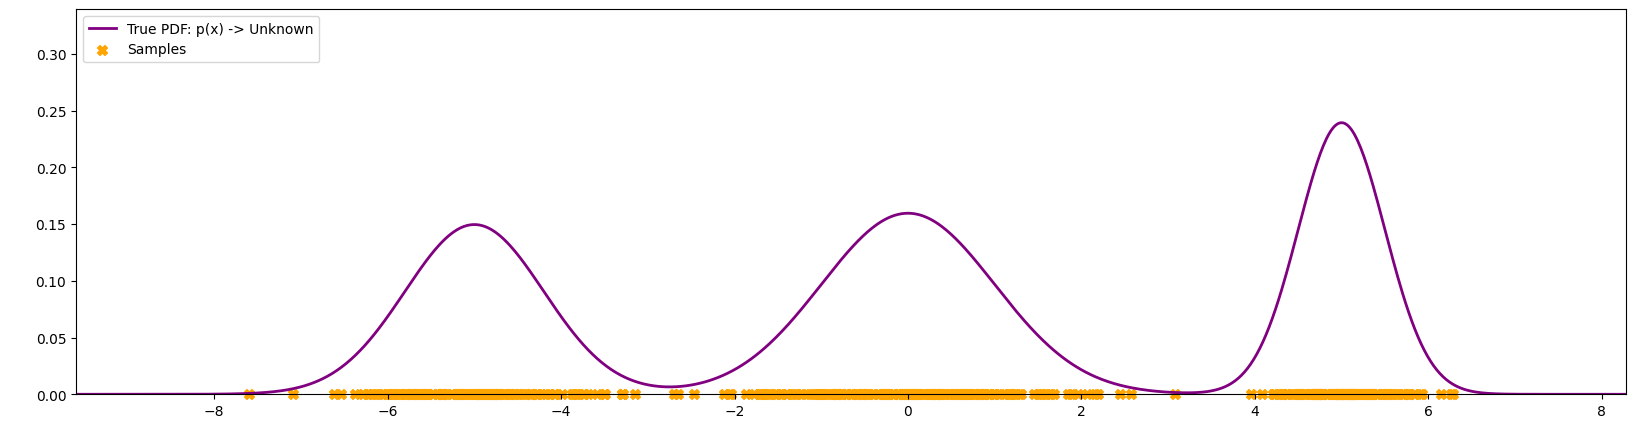

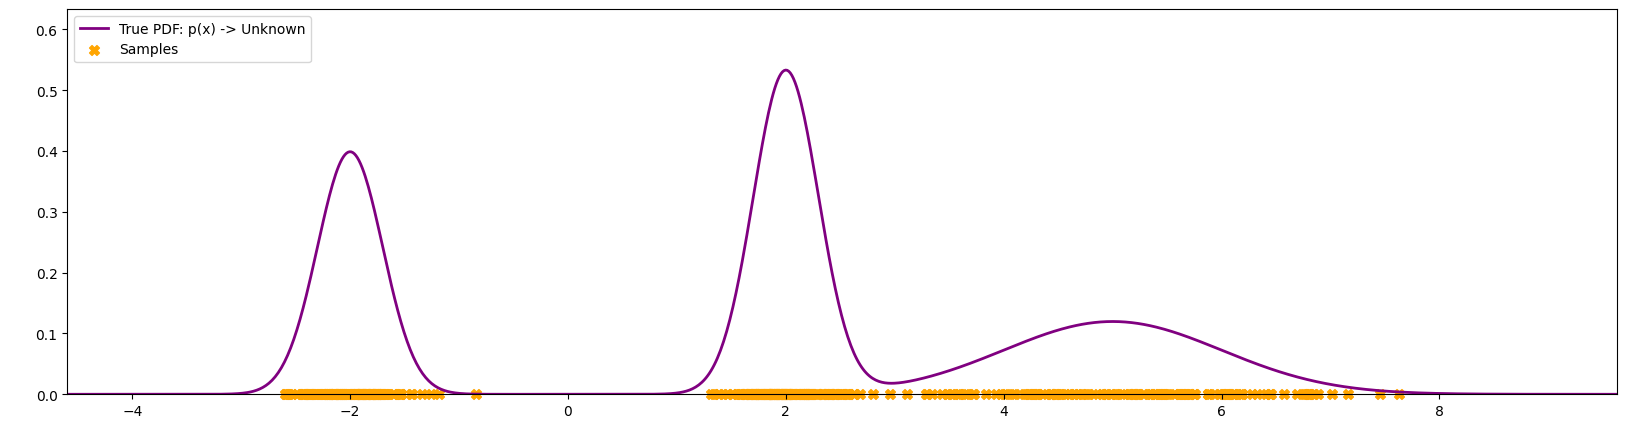

In [30]:
# Plot True pdf at each dimension
for d in range(D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    density = np.zeros_like(x_values)
    for k in range(true_K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    
    # Made the plots a bit wider to better visualize the data
    plt.figure(figsize=(20, 5))
    plt.plot(x_values, density, color='purple', linewidth=2, label='True PDF: p(x) -> Unknown')

    # Plot samples from the pdf
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='orange', marker='X', s=50, label='Samples', clip_on=False)

    plt.ylabel('Probability Density', color='white', fontsize=16)
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(density) + 0.1)
    plt.show()

## Create Mixture of Gaussian (MoG) class to be used EM-based 

The following code generates MoG class to esimate the parameters of the model using EM-based optimization

In [31]:
class MoG:
    def __init__(self, K, D):
        """
        Initialize Mixture of Gaussians with EM optimization
        
        Args:
            K (int): Number of Gaussian components
            D (int): Dimensionality of the input data
        """
        self.K = K
        self.D = D
        
        np.random.seed(42) # set seed for reproducibility

        # Initialize weights (mixing coefficients)
        self.weights = np.ones(self.K) / self.K

        # Initialize means
        self.means = np.random.randn(self.K, self.D) * 2

        # Initialize variances
        self.vars = np.ones((self.K, self.D))

    def _log_multivariate_normal_pdf(self, X, mean, var):
        """
        Compute PDF of multivariate normal distribution for a given data matrix X and the parameters of the distribution.
        Note that this implementation assumes diagonal covariance matrix.
        Args:
            X (numpy.ndarray): Input data of shape (N, D)
            mean (numpy.ndarray): Mean of each dimension (D,).
            var (numpy.ndarray): Variance of each dimension (D,).
        
        Returns:
            prob (numpy.ndarray): Probabilities for each data point (N,).
        """
        diff = X - mean
        log_det = np.sum(np.log(var))
        quad = np.sum(diff * diff / var, axis=1)

        prob = -0.5 * (self.D * np.log(2 * np.pi) + log_det + quad)

        return prob

    def log_likelihood(self, X):
        """
        Compute log likelihood of the data
        Args:
            X (numpy.ndarray): Input data of shape (N, D)
        
        Return:
            ll (numpy.ndarray): log likelihood of shape ()
        """
        N = X.shape[0]
        log_probs = np.zeros((self.K, N))
        
        for k in range(self.K):
            log_probs[k] = self._log_multivariate_normal_pdf(X, self.means[k], self.vars[k])

        log_probs = log_probs + np.log(self.weights[k].reshape(-1, 1))

        log_likelihood = scipy.special.logsumexp(log_probs, axis=0)

        return np.sum(log_likelihood)
    
    def fit(self, X, max_iters=100, tol=1e-6):
        """
        Fit the model using EM algorithm
        
        Args:
            X (np.ndarray): Input data of shape (N, D)
            max_iters (int): Maximum number of EM iterations
            tol (float): Convergence tolerance for log-likelihood

        Return:
            nll_history (list): nll losses at each iteration
        """
        N = X.shape[0]
        prev_ll = -np.inf
        nll_history = []

        for iter in range(max_iters):
            # E-step: Calculate responsibilities
            responsibilities = self._e_step(X)
            
            # M-step: Update parameters
            self._m_step(X, responsibilities)
            
            # Check convergence
            curr_ll = self.log_likelihood(X)
            nll_history.append(-curr_ll)
            if np.abs(curr_ll - prev_ll) < tol:
                print(f'Converged after {iter+1} iterations')
                break
                
            prev_ll = curr_ll
            
        return nll_history
    
    def _e_step(self, X):
        """
        Expectation step: compute responsibilities
        Args:
            X (np.ndarray): Input data of shape (N, D).
        
        Returns:
            responsibilities (numpy.ndarray): Responsibilities p(k|x): the probability that a given sample belongs to the k -th component of the mixture, of shape (N, K).
        """
        N = X.shape[0]
        log_resp = np.zeros((N, self.K)) # log(p(k|x))
        
        # Calculate log responsibilities
        for k in range(self.K):
            log_resp[:, k] = np.log(self.weights[k] + 1e-10) + self._log_multivariate_normal_pdf(X, self.means[k], self.vars[k])
        
        # Subtract max for numerical stability before exp
        log_resp_norm = log_resp - log_resp.max(axis=1, keepdims=True)
        responsibilities = np.exp(log_resp_norm)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) # Normalize
        
        return responsibilities

    def _m_step(self, X, responsibilities):
        """
        Maximization step: update parameters means, vars, and weights
        Args:
            X (np.ndarray): Input data of shape (N, D).
            responsibilities (numpy.ndarray): Responsibilities p(k|x): the probability that a given sample belongs to the k -th component of the mixture, of shape (N, K).
        """
        N = X.shape[0]
        Nk = responsibilities.sum(axis=0)
        
        # Update means
        for k in range(self.K):
            self.means[k] = (responsibilities[:, k:k+1] * X).sum(axis=0) / Nk[k]
        
        # Update covariances
        for k in range(self.K):
            diff = (X - self.means[k])**2
            self.vars[k] = np.sum(responsibilities[:, k:k+1] * diff, axis=0) / Nk[k]
            
            # Add small diagonal term for numerical stability
            self.vars[k] += 1e-6
        
        # Update weights
        self.weights = Nk / N
    
    def sample(self, n_samples):
        """
        Generate samples from the mixture model
        Args:
            n_samples (int): number of samples to be generated
        
        Return:
            samples (torch.Tensor): Generated samples of shape (n_samples, D)
        """
        # Sample component indices
        component_indices = np.random.choice(self.K, size=n_samples, p=self.weights)
        
        # Generate samples from each selected component
        samples = np.zeros((n_samples, self.D))
        for i, k in enumerate(component_indices):
            samples[i] = self.means[k] + np.sqrt(self.vars[k]) * np.random.randn(self.D)
            
        return samples

## Fit a MoG model to data

Converged after 7 iterations


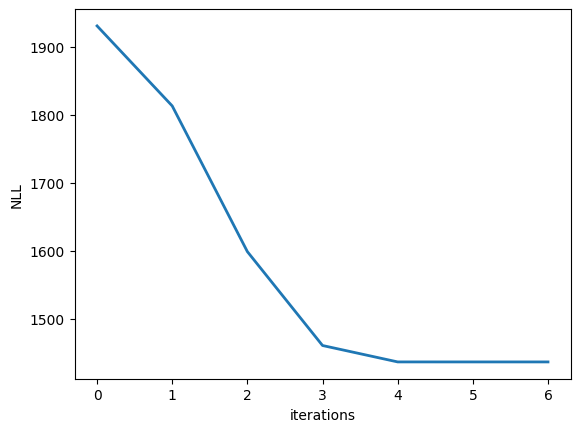

In [32]:
K = 3
D = data.shape[1]
mog = MoG(K=K, D=D)

nll_history = mog.fit(data)

plt.plot(range(len(nll_history)), nll_history, linewidth=2)
plt.ylabel('NLL')
plt.xlabel('iterations')
plt.show()

## Plot True pdf and the Predicted pdf

Plot the true pdf that the data is generated at each dimension and the pdf predicted by MoG

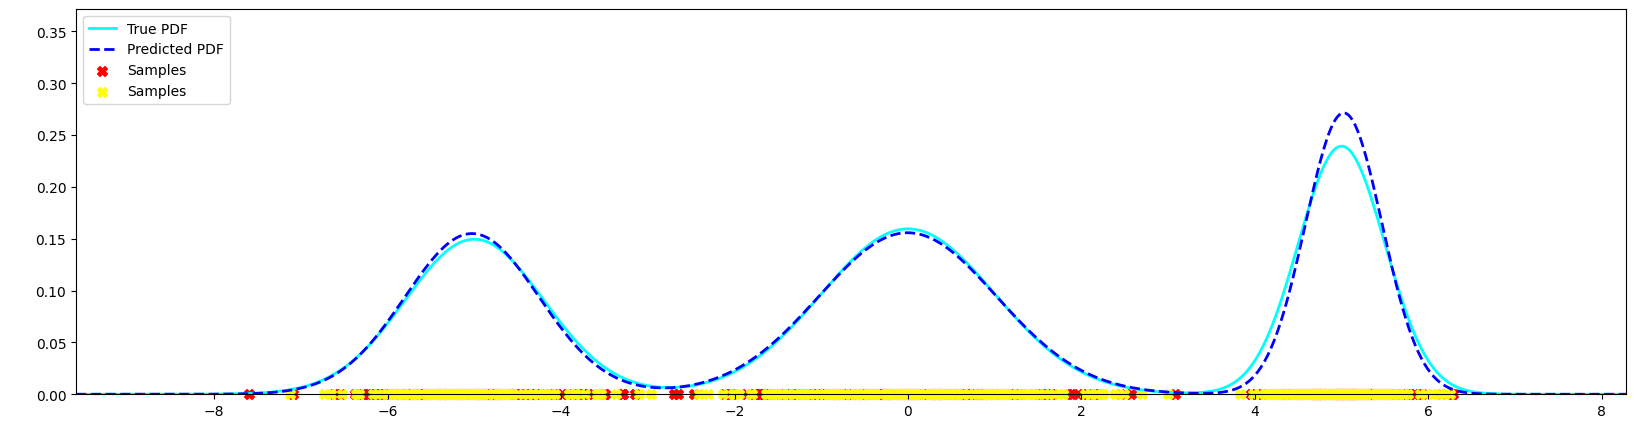

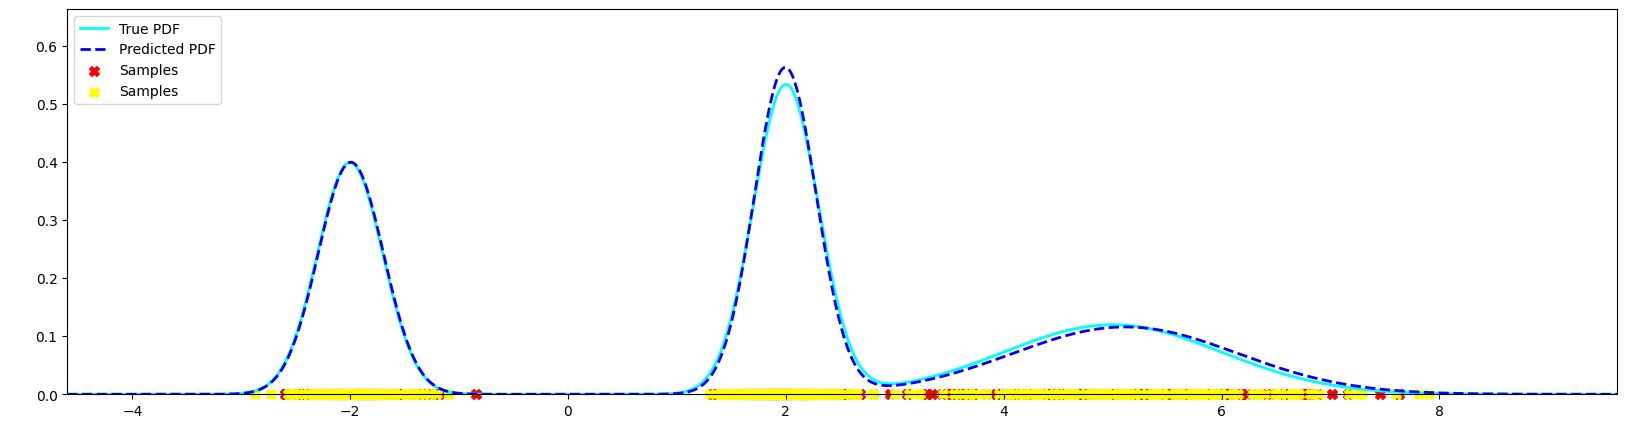

In [ ]:
for d in range(D):
    x_values = np.linspace(min(data[:, d]) - 2, max(data[:, d]) + 2, 1000)

    plt.figure(figsize=(20, 5))
    
    # Plot true density
    density = np.zeros_like(x_values)
    for k in range(true_K):
        pdf = (1 / np.sqrt(2 * np.pi * true_variances[k, d])) * np.exp(-0.5 * ((x_values - true_means[k, d])**2) / true_variances[k, d])
        density += (true_weights[k] * pdf)
    
    plt.plot(x_values, density, color='cyan', linewidth=2, label='True PDF')

    # Plot predicted density
    pred_density = np.zeros_like(x_values)
    for k in range(K):
        pdf = (1 / np.sqrt(2 * np.pi * mog.vars[k, d])) * np.exp(-0.5 * ((x_values - mog.means[k, d])**2) / mog.vars[k, d])
        pred_density += (mog.weights[k] * pdf)
    
    #plt.figure(figsize=(20, 5))
    plt.plot(x_values, pred_density, color='blue', linewidth=2, linestyle='--', label='Predicted PDF')

    # Plot samples generated from true density
    plt.scatter(data[:, d], np.zeros_like(data[:, d]), c='red', marker='X', s=50, label='Samples', clip_on=False)

    # Generate samples from the predicted density and plot
    data_samples = mog.sample(500)
    plt.scatter(data_samples[:, d], np.zeros_like(data_samples[:, d]), c='yellow', marker='X', s=50, label='Samples', clip_on=False)

    plt.ylabel('Probability Density', color='white', fontsize=16)
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.xlim(min(data[:, d]) - 2, max(data[:, d]) + 2)
    plt.ylim(0.0, max(max(density), max(pred_density)) + 0.1)
    plt.show()